In [ ]:
# 3 depths, 1, 2, and 3 hidden layers
# 5 breadths (nodes per layer) 50, 100, 150,200,250
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-49-2b7f51cd6e56>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [ ]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')
labels = data[:,0]
data   = data[:,1:]
dataNorm = data / np.max(data)

# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
#  create a class for the model
def createModel(nUnits, nLayers):
  class ANN(nn.Module):
    def __init__(self,nUnits,nLayers):
      super().__init__()

      # create dictionary to store the layers
      self.layers = nn.ModuleDict()
      self.nLayers = nLayers

      ### input layer
      self.layers['input'] = nn.Linear(784,nUnits)

      ### hidden layers
      for i in range(nLayers):
        self.layers[f'hidden{i}'] = nn.Linear(nUnits,nUnits)

      ### output layer
      self.layers['output'] = nn.Linear(nUnits,10)


    # forward pass
    def forward(self,x):
      # input layer (note: the code in the video omits the relu after this layer)
      x = F.relu( self.layers['input'](x) )

      # hidden layers
      for i in range(self.nLayers):
        x = F.relu( self.layers[f'hidden{i}'](x) )

      # return output layer
      x = self.layers['output'](x)
      return x
  net = ANN(nUnits, nLayers)
  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
  return net, lossfun, optimizer

In [ ]:
def trainTheModel(nUnits, nLayers):
  epochs = 60
  model, lossfun, optimizer = createModel(nUnits, nLayers)

  trainAcc = []
  testAcc = []

  losses = torch.zeros(epochs)
  for epoch in range(epochs):
    trainBatchAcc = []
    batchLoss = []

    for X,y in train_loader:
      # forward pass
      yHat = model(X)
      loss = lossfun(yHat, y)

      # back prop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss.append(loss.item())

      # training accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      trainBatchAcc.append( accuracyPct )

    trainAcc.append(np.mean(trainBatchAcc))
    losses[epoch] = np.mean(batchLoss)

    model.eval()
    X,y = next(iter(test_loader))
    with torch.no_grad():
      yHat = model(X)
    testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))
    # nParams = sum(p.numel() for p in model.parameters() if p.requires_grad)
    model.train()
  return trainAcc, testAcc

# a function that trains the model

# def trainTheModel(nUnits,nLayers):

#   # number of epochs
#   numepochs = 60

#   # create a new model
#   net,lossfun,optimizer = createModel(nUnits,nLayers)

#   # initialize losses
#   losses    = torch.zeros(numepochs)
#   trainAcc  = []
#   testAcc   = []


#   # loop over epochs
#   for epochi in range(numepochs):

#     # loop over training data batches
#     batchAcc  = []
#     batchLoss = []
#     for X,y in train_loader:

#       # forward pass and loss
#       yHat = net(X)
#       loss = lossfun(yHat,y)

#       # backprop
#       optimizer.zero_grad()
#       loss.backward()
#       optimizer.step()

#       # loss from this batch
#       batchLoss.append(loss.item())

#       # compute accuracy
#       matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
#       matchesNumeric = matches.float()             # convert to numbers (0/1)
#       accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
#       batchAcc.append( accuracyPct )               # add to list of accuracies
#     # end of batch loop...

#     # now that we've trained through the batches, get their average training accuracy
#     trainAcc.append( np.mean(batchAcc) )

#     # and get average losses across the batches
#     losses[epochi] = np.mean(batchLoss)

#     # test accuracy
#     X,y = next(iter(test_loader)) # extract X,y from test dataloader
#     with torch.no_grad(): # deactivates autograd
#       yHat = net(X)

#     # compare the following really long line of code to the training accuracy lines
#     testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

#   # end epochs

#   # function output
#   return trainAcc,testAcc


In [ ]:
# this cell takes ~2 mins
# # define the model parameters
numlayers = range(1,4)         # number of hidden layers
numunits  = np.arange(50,251,50) # units per hidden layer
# accuracies  = np.zeros((2, len(numunits),len(numlayers)))
Testaccuracies = np.zeros((len(numunits),len(numlayers)))
Trainaccuracies = np.zeros((len(numunits),len(numlayers)))


# start the experiment!
for unitidx in range(len(numunits)):
  for layeridx in range(len(numlayers)):

    # create a fresh model instance
    trainAcc, testAcc = trainTheModel(numunits[unitidx],numlayers[layeridx])
    # accuracies[0, unitidx,layeridx] = np.mean(trainAcc[-5:]) #average of last 5 accuracies to get good final reading
    # accuracies[1, unitidx, layeridx] = np.mean(testAcc[-5:])

    Trainaccuracies[unitidx,layeridx] = np.mean(trainAcc[-5:])
    Testaccuracies[unitidx,layeridx] = np.mean(testAcc[-5:])
    print(f'Finished units {unitidx+1}/{len(numunits)} and layers {layeridx+1}/{len(numlayers)}')



Finished units 1/5 and layers 1/3
Finished units 1/5 and layers 2/3
Finished units 1/5 and layers 3/3
Finished units 2/5 and layers 1/3
Finished units 2/5 and layers 2/3
Finished units 2/5 and layers 3/3
Finished units 3/5 and layers 1/3
Finished units 3/5 and layers 2/3
Finished units 3/5 and layers 3/3
Finished units 4/5 and layers 1/3
Finished units 4/5 and layers 2/3
Finished units 4/5 and layers 3/3
Finished units 5/5 and layers 1/3
Finished units 5/5 and layers 2/3
Finished units 5/5 and layers 3/3


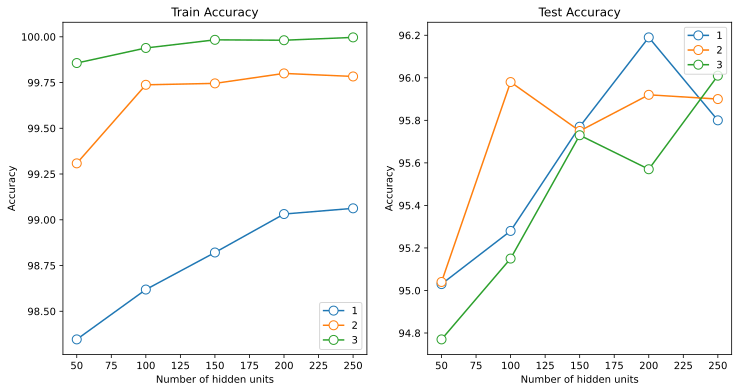

In [ ]:
# show accuracy as a function of model depth
fig,ax = plt.subplots(1,2,figsize=(12,6))

ax[0].plot(numunits,Trainaccuracies,'o-',markerfacecolor='w',markersize=9)
# ax[0].plot(numunits[[0,-1]],[33,33],'--',color=[.8,.8,.8])
# ax[0].plot(numunits[[0,-1]],[67,67],'--',color=[.8,.8,.8])
ax[0].legend(numlayers)
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Number of hidden units')
ax[0].set_title('Train Accuracy')

ax[1].plot(numunits,Testaccuracies,'o-',markerfacecolor='w',markersize=9)
# ax[1].plot(numunits[[0,-1]],[33,33],'--',color=[.8,.8,.8])
# ax[1].plot(numunits[[0,-1]],[67,67],'--',color=[.8,.8,.8])
ax[1].legend(numlayers)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Number of hidden units')
ax[1].set_title('Test Accuracy')
plt.show()


- Performance increases with more layers and more units
- ironically this is the opposite conclusion from running the same experiment on the irs dataset
##Takeaways
- conclusions might not be consistent across experiments
- must approach as an experimental scientist
- more complex problems will benifit from deeper networks
- iris data set is simple which is why fewer layers was better